In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1,3'
import logging

import numpy as np
from scipy import ndimage
from skimage import morphology
from skimage import segmentation
from skimage.feature import peak_local_max
from skimage.exposure import equalize_adapthist
from skimage.exposure import rescale_intensity
from skimage.measure import label
import os

from PIL import Image 
from scipy import signal
import cv2

import numpy as np

import imageio
import matplotlib.pyplot as plt

# import tensorflow as tf
# from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import os
import skimage.io as skio
import numpy as np 
import matplotlib.image as mpimg
from math import nan 


import numpy as np
import logging
import skimage.io as skio
import matplotlib.pyplot as plt
import cv2

In [2]:
root_path = r'/data/sunrui/celldata/20230426_hesc_Mixl1_yy/8H_ch1_mcp_ch2_sir/r03c06f02ch1/'
file_name = r'r03c06f02ch1.tif'

In [3]:
def histogram_normalization(image, kernel_size=None):
    """Pre-process images using Contrast Limited Adaptive
    Histogram Equalization (CLAHE).

    If one of the inputs is a constant-value array, it will
    be normalized as an array of all zeros of the same shape.

    Args:
        image (numpy.array): numpy array of phase image data.
        kernel_size (integer): Size of kernel for CLAHE,
            defaults to 1/8 of image size.

    Returns:
        numpy.array: Pre-processed image data with dtype float32.
    """
    if not np.issubdtype(image.dtype, np.floating):
        logging.info('Converting image dtype to float')
    image = image.astype('float32')

    for batch in range(image.shape[0]):
        for channel in range(image.shape[-1]):
            X = image[batch, ..., channel]
            sample_value = X[(0,) * X.ndim]
            if (X == sample_value).all():
                # TODO: Deal with constant value arrays
                # https://github.com/scikit-image/scikit-image/issues/4596
                logging.warning('Found constant value array in batch %s and '
                                'channel %s. Normalizing as zeros.',
                                batch, channel)
                image[batch, ..., channel] = np.zeros_like(X)
                continue

            # X = rescale_intensity(X, out_range='float')
            X = rescale_intensity(X, out_range=(0.0, 1.0))
            X = equalize_adapthist(X, kernel_size=kernel_size)
            image[batch, ..., channel] = X
    return image

In [4]:

# 腐蚀操作
def grayscale_erosion(image, structuring_element):

    for batch in range(image.shape[0]):
        for channel in range(image.shape[-1]):
            X = image[batch, ..., channel]
            h, w = X.shape
            h_se, w_se = structuring_element.shape
            eroded_image = np.zeros_like(X)
            for i in range(h):
                for j in range(w):
                    min_value = float('inf')  # 初始化为无穷大，确保会被任何像素值取代

                    # 遍历结构元素的所有像素
                    for m in range(h_se):
                        for n in range(w_se):
                            if structuring_element[m, n] == 1:
                                # 边界处理，如果越界则忽略该像素
                                if i + m >= 0 and i + m < h and j + n >= 0 and j + n < w:
                                    current_value = X[i + m, j + n]
                                    min_value = min(min_value, current_value)

            eroded_image[i, j] = min_value
            image[batch, ..., channel] = eroded_image
    return image

In [5]:

#边缘检测操作
def edge_enhancement(input_image):
    # 定义Sobel算子
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

    # 计算图像梯度
    gradient_x = cv2.filter2D(input_image, -1, sobel_x)
    gradient_y = cv2.filter2D(input_image, -1, sobel_y)

    # 计算梯度幅值
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)

    # 边缘增强
    enhanced_image = input_image + gradient_magnitude

    return enhanced_image




In [6]:
#canny边缘增强
def edge_enhancement_canny(image, threshold1, threshold2):
    for batch in range(image.shape[0]):
        for channel in range(image.shape[-1]):
            X = image[batch, ..., channel]
             # 边缘检测
            edges = cv2.Canny(X, threshold1, threshold2)

            # 边缘增强
            enhanced_image = X + 2*edges
            image[batch, ..., channel] = enhanced_image
    
    # # 边缘检测
    # edges = cv2.Canny(input_image, threshold1, threshold2)

    # # 边缘增强
    # enhanced_image = input_image + edges

    return image

# # 设置Canny算法的阈值
# threshold1 = 100
# threshold2 = 200

# # 边缘增强
# enhanced_image = edge_enhancement_canny(input_image, threshold1, threshold2)


In [7]:
# 步骤一 进口轮子 编写函数


# 加载函数
# 去掉高于平均背景水平的像素
def background_noise(image,noise_level= 174):
    if not np.issubdtype(image.dtype, np.floating):
        logging.info('Converting image dtype to float')
    image = image.astype('float32')

    for batch in range(image.shape[0]):
        for channel in range(image.shape[-1]):
            img = image[batch, ..., channel]
            img[img<noise_level] = noise_level
            image[batch, ..., channel] = img
    return image
# 均值滤波
def blur_proc(image):
    if not np.issubdtype(image.dtype, np.floating):
        logging.info('Converting image dtype to float')
    image = image.astype('float32')

    for batch in range(image.shape[0]):
        for channel in range(image.shape[-1]):
            img = image[batch, ..., channel]
            normal_image = cv2.blur(img,(20,20))
            image[batch, ..., channel] = normal_image
    return image

#均衡化
def his(image):


    for batch in range(image.shape[0]):
        for channel in range(image.shape[-1]):
            img = image[batch, ..., channel]
            normal_image = cv2.equalizeHist(img)
            image[batch, ..., channel] = normal_image
    return image

def float32_to_uint8(float_value):
    # 将float32的值限制在0到1之间
    # float_value = np.clip(float_value, 0.0, 1.0)
    
    # # 将float32乘以255，并进行舍入
    # uint8_value = np.round(float_value * 255.0, decimals=0).astype(np.uint8)
    
    scaled_image = (float_value - np.min(float_value)) / (np.max(float_value) - np.min(float_value))
    uint8_value = np.round(scaled_image * 255.0).astype(np.uint8)

    return uint8_value


def uint8_to_uint16(uint8_array):
    # 将float32的值限制在0到1之间
    # float_value = np.clip(float_value, 0.0, 1.0)
    
    # # 将float32乘以255，并进行舍入
    # uint8_value = np.round(float_value * 255.0, decimals=0).astype(np.uint8)
        
    scaled_array = (uint8_array.astype(np.float32) / 255.0) * 65535.0
    uint16_array = scaled_array.astype(np.uint16)

    return uint16_array



In [8]:


img_raw = skio.imread(root_path +'/01/'+ file_name, plugin="tifffile")
print(img_raw.shape)


#读取一系列图像
# raw_path = root_path#原始图像路径
# imgfiles = [os.path.join(raw_path, f) for f in os.listdir(raw_path) if f.endswith('.tif') or f.endswith('.tiff')]
# imgfiles.sort()

# img_raw = []
# print(len(imgfiles))
# for i in range(len(imgfiles)):
#     img_raw.append(skio.imread(imgfiles[i]).astype(np.uint16))
# print(len(img_raw))
# img_raw = np.array(img_raw)
# print(img_raw.shape)
# print(img_raw.shape[0])

(329, 1080, 1080)


(329, 1080, 1080)
x:
(329, 1080, 1080, 1)
uint16
.............................
(329, 1080, 1080, 1)
float32
img_pre_save:
float32
(329, 1080, 1080, 1)
uint8
(329, 1080, 1080, 1)


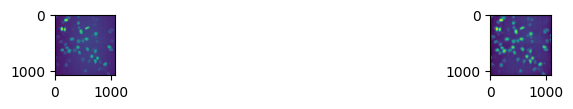

In [9]:
# 步骤二
# 一次走完流程
# 加载图片 Load Image (single)
# x = skio.imread('D:\/new_folder\human_f01_stack\max_human_stack_30_100.tif', plugin="tifffile")
#file_name = 'r07c05f02.tif kept stack.tif'
# x = skio.imread(r'D:\new_folder\deepcell-tf-master\mySegment\100 slices\/'+file_name, plugin="tifffile")
#x = skio.imread(r'D:\new_folder\deepcell-tf-master\my_post_process\new_cell_hesc\r06c02f01-ch1.tif', plugin="tifffile")

# root_path = r'/data/sunrui/celldata/r03c03f01/'
# file_name = r'r03c03f01.tif'

# x = skio.imread(root_path + file_name, plugin="tifffile")
# print(x.shape)


# x = skio.imread(r'/data/sunrui/celldata/20230414_hesc_Mixl1_yy/r03c03f01/r03c03f01.tif',plugin="tifffile")
# print(x.shape)
# x = np.expand_dims(x,axis=3)
# # x = np.expand_dims(x,axis=3)
# print(x.dtype)

x = img_raw
print(x.shape)
x = np.expand_dims(x,axis=3)
print('x:')
print(x.shape)
print(x.dtype)
print('.............................')
# x = x[1:20,:,:,:]
plt.subplot(1,7,1)
plt.imshow(x[3,...,0])

batch = 50
total_frames = x.shape[0]
img_pre_save = np.zeros(x.shape,dtype='float32')
print(img_pre_save.shape)
print(img_pre_save.dtype)
# x = x.astype('uint8')
# img_pre = background_noise(x)
# img_pre = blur_proc(img_pre)
# img_pre = his(x)
# img_pre = his(x)
#直方图均衡化
# img_pre=histogram_normalization(x)
# print('histogram_normalization DONE!')
#腐蚀操作
# structuring_element = np.ones((3, 3), np.uint8)
# img_pre = grayscale_erosion(img_pre, structuring_element)
# print('grayscale_erosion DONE!')
#Canny边缘检测



## 用于常规图像处理
for i in range(0, total_frames, batch):
    img_raw = x[i:i+batch,:,:,:]
    # img_raw = x[1:10,:,:]
    # print(i)
    # print('img_raw:')
    # print(img_raw.dtype)
    # print(img_raw.shape)
    # plt.subplot(1,7,2)
    # plt.imshow(img_raw[3,...,0])  
    # print('.....................')


    img_pre = img_raw
    img_pre=histogram_normalization(img_pre)
    # print('histogram_normalization DONE!')
    # print('img_his:')
    # print(img_pre.dtype)
    # print(img_pre.shape)
    # plt.subplot(1,7,3)
    # plt.imshow(img_pre[3,...,0])  
    # print('.....................')

    # img_pre = (img_pre * 255).astype(np.uint8)
    img_pre = float32_to_uint8(img_pre)
    threshold1 = 100
    threshold2 = 200
    # print('img_32_TO_8:')
    # print(img_pre.shape)
    # print(img_pre.dtype)
    # print('.....................')

    img_pre = edge_enhancement_canny(img_pre, threshold1, threshold2)
    # print('img_edge_enhance:')
    # print(img_pre.dtype)
    # print(img_pre.shape)
    # plt.subplot(1,7,4)
    # plt.imshow(img_pre[3,...,0])  
    # print('.....................')

    img_pre = uint8_to_uint16(img_pre)
    # print('img_8_TO_16:')
    # print(img_pre.dtype)
    # print(img_pre.shape)
    # print('.....................')
    
    img_pre = background_noise(img_pre)
    # print('img_backgroundNoise:')
    # print(img_pre.dtype)
    # print(img_pre.shape)
    # plt.subplot(1,7,5)
    # plt.imshow(img_pre[3,...,0])  
    # print('.....................')

    img_pre = blur_proc(img_pre)
    # print('img_blur_proc:')
    # print(img_pre.dtype)
    # print(img_pre.shape)
    # plt.subplot(1,7,6)
    # plt.imshow(img_pre[3,...,0])  
    # print('.....................')

    img_pre_save[i:i+batch,:,:,:] = img_pre


# print(img_pre.dtype)
# img_pre = (img_pre * 255).astype(np.uint8)

# print(img_pre.shape)
# threshold1 = 100
# threshold2 = 200

# img_pre = edge_enhancement_canny(img_pre, threshold1, threshold2)
# print(img_pre.shape)


# img_pre = img_pre.astype('uint16')
# 展示处理结果

print('img_pre_save:')
print(img_pre_save.dtype)
print(img_pre_save.shape)
img_pre_save = float32_to_uint8(img_pre_save)
print(img_pre_save.dtype)
print(img_pre_save.shape)
plt.subplot(1,7,7)
plt.imshow(img_pre_save[3,...,0])
plt.show()

In [10]:
# 步骤三
# 保存步骤二中处理过的图片
from tifffile import imread, imwrite
saveDir = root_path + r'/PRE/'
if not os.path.exists(saveDir):
    os.makedirs(saveDir)
imwrite(saveDir+"test.tif",img_pre_save)


In [11]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [12]:
def show_anns(anns):
    if len(anns) == 0:
        return
    # 按面积大小对注释进行排序
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    img_shape = (sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1],1)


    
    # 创建一个空白图像
    # img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img = np.zeros(img_shape, dtype=np.uint8)
    img[:,:,0] = 0
    for i, ann in enumerate(sorted_anns):
        mask_thresholdU = 5000
        mask_thresholdD = 1000
        mask_area = ann['area']
        m = ann['segmentation']
        if(mask_area < mask_thresholdU and mask_area > mask_thresholdD):
            # gray_value = 2*i + 1
            gray_value = i + 1
            # color_mask = np.concatenate([np.random.random(3), [0.35]])
            img[m] = gray_value
        
        
        # print(img.shape)
    img = img
    
    return img

In [13]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(
    sam,
    pred_iou_thresh = 0.95,
    crop_overlap_ratio=0,
    min_mask_region_area = 1000,
    )

In [14]:
# image = cv2.imread('images/dog.jpg')
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
import skimage.io as skio
from tifffile import imread, imwrite

# #读取一系列图像
# raw_path = root_path#原始图像路径
# imgfiles = [os.path.join(raw_path, f) for f in os.listdir(raw_path) if f.endswith('.tif') or f.endswith('.tiff')]
# imgfiles.sort()

# img_raw = []
# print(len(imgfiles))
# for i in range(len(imgfiles)):
#     img_raw.append(skio.imread(imgfiles[i]).astype(np.uint16))
# print(len(img_raw))
# img_raw = np.array(img_raw)
# print(img_raw.shape)
# print(img_raw.shape[0])


img_raw = skio.imread(root_path + r'/PRE/test.tif',plugin="tifffile")
# img_raw = skio.imread(root_path + r'/PRE/test_seg.tif',plugin="tifffile")
print(img_raw.shape)
# img_raw = np.expand_dims(img_raw,axis=3)
# x = np.expand_dims(x,axis=3)
print(img_raw.dtype)

# #uint16转uint8
# max_val = np.max(img_raw)
# min_val = np.min(img_raw)

# # 归一化处理
# arr_normalized = (img_raw - min_val) * 255 / (max_val - min_val)

# # 将归一化后的数组转换为 uint8 类型
# arr_uint8 = arr_normalized.astype(np.uint8)

img = img_raw


(329, 1080, 1080, 1)
uint8


In [15]:

image_folder =root_path + r'/01_GT/SAMSEG/'
if not os.path.exists(image_folder):
    os.makedirs(image_folder)

for i in range(img.shape[0]):
# for i in range(1):
    image = img[i]
    #uint16转换为uint8
    # uint16_img = image
    # uint16_img -= image.min()
    # uint16_img = uint16_img / (uint16_img.max()-uint16_img.min())
    # uint16_img *= 255
    # uint8_img = np.uint8(uint16_img)

    image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)

    # image = image.astype('uint8')
    # image = cv2.imread(r'/data/sunrui/celldata/20230414_hesc_Mixl1_yy/r03c03f01/01/t000.tif')
    # image = imread(r'/data/sunrui/celldata/20230414_hesc_Mixl1_yy/r03c03f01/01/t000.tif')

    # print(image.dtype)
    # print(image.shape)
    # print('-------------------------------------------------------')

    #生成masks
    masks = mask_generator.generate(image)
    mask_result = show_anns(masks)
    # print(mask_result.shape)

    # 图片保存的文件夹路径
    
    image_path = os.path.join(image_folder, f'man_seg{i:03d}.tif')
    imwrite(image_path,mask_result)

RuntimeError: CUDA out of memory. Tried to allocate 72.00 MiB (GPU 0; 10.75 GiB total capacity; 2.58 GiB already allocated; 6.50 MiB free; 2.64 GiB reserved in total by PyTorch)

In [ ]:
print(mask_result.shape)
print(mask_result.dtype)

In [ ]:

import cv2
import numpy as np
import skimage.io as skio
import os

In [ ]:

# 读取一系列图像
raw_path = root_path + '/01_GT/SAMSEG/'  # 原始图像路径
imgfiles = [os.path.join(raw_path, f) for f in os.listdir(raw_path) if f.endswith('.tif') or f.endswith('.tiff')]
imgfiles.sort()

img_raw = []

print(len(imgfiles))
for i in range(len(imgfiles)):
    img_raw.append(skio.imread(imgfiles[i]).astype(np.uint16))
print(len(img_raw))
img_raw = np.array(img_raw)
print(img_raw.shape)

# 创建与图像序列大小相同的空白图像
img_post = np.zeros(img_raw.shape, dtype=np.uint8)
print(img_post.shape)

# 遍历图像序列
for i in range(img_raw.shape[0]):
    image = img_raw[i, :, :, 0]

    # 获取图像的最小灰度值和最大灰度值
    min_intensity = np.min(image)
    max_intensity = np.max(image)

    # 遍历灰度值范围
    for intensity in range(min_intensity, max_intensity + 1):
        # 创建一个与原始图像大小相同的空白图像
        gray_value_image = (image == intensity).astype('uint8') * 255

        # 定义结构元素（这里使用3x3的正方形结构元素）
        structuring_element = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

        # 进行腐蚀操作
        eroded_image_0 = cv2.erode(gray_value_image, structuring_element)
        eroded_image_1 = cv2.erode(eroded_image_0, structuring_element)
        # 进行膨胀操作
        dilated_image_0 = cv2.dilate(eroded_image_1, structuring_element)
        dilated_image_1 = cv2.dilate(dilated_image_0, structuring_element)

        # 计算非零像素的数量（PRE）
        non_zero_pixels_pre = np.count_nonzero(gray_value_image)
        # print('pre:')
        # print(non_zero_pixels_pre)

        # 计算非零像素的数量（POST）
        non_zero_pixels_post = np.count_nonzero(dilated_image_1)
        # print('post:')
        # print(non_zero_pixels_post)

        # 结果
        post_result = (dilated_image_1 / 255) * intensity
        post_result = post_result.astype('uint8')
        ss = np.max(post_result)
        # print('label:')
        # print(ss)
        # print('...................................................')

        # 更新img_post
        if non_zero_pixels_post > 1000:
            img_post[i, :, :, 0] += post_result


In [ ]:
print(img_post.shape)
print(img_post.dtype)
img_post_16 = img_post.astype(np.uint16)

In [ ]:
print(np.max(img_post_16))
print(np.mean(img_post_16))
print(np.min(img_post_16))

In [ ]:
import skimage.io as skio
from tifffile import imread, imwrite
import matplotlib.pyplot as plt

image_folder =root_path + r'/01_GT/SEG/'
if not os.path.exists(image_folder):
    os.makedirs(image_folder)

for i in range(img_post.shape[0]):
    image_path = os.path.join(image_folder, f'man_seg{i:03d}.tif')
    imwrite(image_path,img_post_16[i,:,:,0])


plt.imshow(img_post_16[14,:,:,0])
plt.show()